# Notebook to analyze STARsolo simulation data

The purpose of this notebook is to provide an analysis of the performance of different tools on the simulated data
(realistic intron/exon read distribution, but no gene-mulitmapping reads) from the [STARsolo manuscript](https://www.biorxiv.org/content/10.1101/2021.05.05.442755v1).



In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scanpy
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
def load_fry(frydir, which_counts=['S','A'], verbose=False):
    import json
    import os
    meta_info = json.load(open(os.path.sep.join([frydir, "meta_info.json"])))
    ng = meta_info['num_genes']
    usa_mode = meta_info['usa_mode']

    if usa_mode:
        assert(len(which_counts) > 0)
        if verbose:
            print("processing input in USA mode, will return {}".format("+".join(which_counts)))
    elif verbose:
        print("processing input in standard mode, will return spliced count")

    af_raw = scanpy.read_mtx(os.path.sep.join([frydir, "alevin", "quants_mat.mtx"]))
    ng = int(ng/3) if usa_mode else ng
    afg = [ l.rstrip() for l in open(os.path.sep.join([frydir, "alevin", "quants_mat_cols.txt"])).readlines()][:ng]
    afg_df =  pd.DataFrame(afg, columns=["gene_ids"])
    afg_df = afg_df.set_index("gene_ids")
    
    abc = [ l.rstrip() for l in open(os.path.sep.join([frydir, "alevin", "quants_mat_rows.txt"])).readlines() ]
    abc_df = pd.DataFrame(abc, columns=['barcodes'])
    abc_df.index = abc_df['barcodes']
    
    x = af_raw.X
    if usa_mode:
        rd = {'S' : range(0,ng), 'U' : range(ng, 2*ng), 'A' : range(2*ng,3*ng)}
        o = x[:, rd[which_counts[0]]]
        for wc in which_counts[1:]:
            o += x[:, rd[wc]]
    else:
        o = x
        
    af = scanpy.AnnData(o.T, var=abc_df, obs=afg_df)
    af = af.T
    return af

In [3]:
def read_kb(ipath):
    mpath = os.path.sep.join([ipath,'cells_x_genes.mtx'])
    gpath = os.path.sep.join([ipath,'cells_x_genes.genes.txt'])
    bpath = os.path.sep.join([ipath,'cells_x_genes.barcodes.txt'])
    
    x = scanpy.read_mtx(mpath)
    bc = pd.read_csv(bpath, names=['barcodes'])
    g = pd.read_csv(gpath, names=['gene_ids'])
    g.gene_ids = g.gene_ids.str.split('.').str.get(0)
    bc = bc.set_index('barcodes')
    g = g.set_index('gene_ids')

    x.var = g
    x.obs = bc
    
    return x 

In [4]:
def read_sim(simdir):
    cf = 'cells.tsv'
    gf = 'genes.tsv'
    mf = 'matrix.mtx'
    
    sim_raw = scanpy.read_mtx(os.path.sep.join([simdir, mf]))
    genes = [ l.rstrip() for l in open(os.path.sep.join([simdir, gf])).readlines() ]
    genes_df = pd.DataFrame(genes, columns=["gene_ids"])
    genes_df = genes_df.set_index("gene_ids")
    
    barcodes = [ l.rstrip() for l in open(os.path.sep.join([simdir, cf])).readlines()]
    barcodes_df = pd.DataFrame(barcodes, columns=["barcodes"])
    barcodes_df = barcodes_df.set_index("barcodes")
    
    mat = scanpy.AnnData(sim_raw.X, var=barcodes_df, obs=genes_df)
    mat = mat.T
    return mat

In [5]:
def sp_corr_df(d1, d2, shared, shared_cells, kind="cells", thresh=1):
    '''
    Given 2 AnnData objects, a list of shared genes `shared` and 
    a list of shared cells `shared_cells`, compute the pariwise spearman 
    correlation of type `kind`.  If `kind` is "cells", then compute the 
    cellwise spearman correlations, if it is "genes" compute the genewise
    spearman correlations.  The result is a distribution (list) of correlation
    values.
    '''
    a = d1[shared_cells, shared].X.copy()
    b = d2[shared_cells, shared].X.copy()
    if kind == "cells":
        corrs = np.zeros(len(shared_cells))
        for i,c in enumerate(shared_cells):
            sr,p = sp.stats.spearmanr(a[i,:].toarray()[0], b[i,:].toarray()[0])
            corrs[i]=sr
    elif kind == "genes":
        a = a.T.tocsr()
        b = b.T.tocsr()
        corrs = np.zeros(len(shared))
        for i,c in enumerate(shared):
            sr,p = scipy.stats.spearmanr(a[i,:].toarray()[0], b[i,:].toarray()[0])
            corrs[i]=sr
    return corrs

In [6]:
def maximum (A, B):
    '''
    Select the maximum, entry-wise among matricies A and B.    
    '''
    # https://stackoverflow.com/questions/19311353/element-wise-maximum-of-two-sparse-matrices
    BisBigger = A-B
    BisBigger.data = np.where(BisBigger.data < 0, 1, 0)
    return A - A.multiply(BisBigger) + B.multiply(BisBigger)

In [7]:
def get_metrics(truth, pred_in):
    '''
    Compute and return the metrics we are evaluating.
    '''  
    shared_obs = pred_in.obs.index.intersection(truth.obs.index)
    shared_var = pred_in.var.index.intersection(truth.var.index)

    truth_filt = truth[shared_obs, shared_var].copy()
    pred = pred_in[shared_obs, shared_var].copy()
    entry_rd = (pred.X - truth_filt.X) / maximum(truth_filt.X, pred.X)
    entry_ard_nonan = np.abs(entry_rd[~np.isnan(entry_rd)])
    mard_drop_nan = entry_ard_nonan.mean()
    
    entry_rdc = entry_rd.copy()
    entry_rdc[np.isnan(entry_rdc)] = 0.0
    mard_nan_zero = np.abs(entry_rdc).mean()
    
    spearmans = sp_corr_df(truth_filt, pred, pred.var_names, pred.obs_names)
    
    fps = [np.logical_and(truth_filt.X[i,:].toarray() == 0, pred.X[i,:].toarray() > 0).sum() for i in range(pred.X.shape[0])]
    num_expressed = [ np.sum(truth_filt.X[i,:].toarray() > 0) for i in range(pred.X.shape[0])]
    
    fp_gene_per_cell = np.mean(np.array(fps)/np.array(num_expressed))
  
    fns = [np.logical_and(truth_filt.X[i,:].toarray() > 0, pred.X[i,:].toarray() == 0).sum() for i in range(pred.X.shape[0])]
    #num_expressed = [ np.sum(truth_filt.X[i,:].toarray() > 0) for i in range(pred.X.shape[0])]
    
    fn_gene_per_cell = np.mean(np.array(fns)/np.array(num_expressed))
    
    rd = {'rd' : entry_rd, 'mard' : mard_nan_zero, 'mard_drop_nan' : mard_drop_nan,
          'spearmans' : spearmans, 'fp_gene_per_cell' : fp_gene_per_cell, 
          'fn_gene_per_cell' : fn_gene_per_cell}
    return rd

In [8]:
def print_summary_metrics(resdict):
    print('Mean per-cell Spearman correlation: {:.4f}'.format(resdict['spearmans'].mean()))
    print('MARD (dropping NANs) : {:.4f}'.format(resdict['mard_drop_nan']))
    print('MARD (setting NANs = 0) : {:.4f}'.format(resdict['mard']))
    print('rFP / cell : {:.4f}%'.format(100*resdict['fp_gene_per_cell']))
    print('rFN / cell : {:.4f}%'.format(100*resdict['fn_gene_per_cell']))

In [9]:
def get_shared(list_of_annd):
    shared_cells = list_of_annd[0].obs_names
    shared_genes = list_of_annd[0].var_names
    for annd in list_of_annd[1:]:
        shared_cells &= annd.obs_names
        shared_genes &= annd.var_names 
    return shared_cells, shared_genes

In [10]:
def legend_without_duplicate_labels(ax, loc='lower right'):
    '''
    from : https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib
    '''
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc=loc)

In [11]:
colors = {'STARsolo' : (200/255.0, 184/255.0, 114/255.0), 
          'alevin-fry (splici, sketch)' : (106/255.0, 123/255.0, 197/255.0) , 
          'alevin-fry (txome, sketch)' : (117/255.0, 0/255.0, 117/255.0), 
          'kallisto|bustools' : (191/255.0, 114/255.0, 106/255.0), 
          'alevin-fry (splici, sla)' : (0/255.0, 118/255.0, 0/255.0)}

In [12]:
def plot_spearman_dists(mdict):
    sns.set_context('poster')#, font_scale=1.4, rc={"lines.linewidth": 2})
    sns.set_style('white')
    datalist = []
    name_order = []
    for i, (mn, m) in enumerate(mdict.items()):
        name_order.append(mn)
        datalist += [(mn, e) for e in m['spearmans']]

    data = pd.DataFrame.from_records(datalist, columns=['method', 'per-cell Spearman corr.'])
    g = sns.boxenplot(data=data, y='method', x="per-cell Spearman corr.", hue='method', 
                palette=colors, linewidth=0.5, dodge=False)
    g.set_xlabel('per/cell Spearman correlation')
    g.set_ylabel('method')
    fig = plt.gcf()
    fig.set_size_inches(10,8)
    sns.despine()

In [13]:
def get_res_summary(mdict):
    datalist = []
    for mn, m in mdict.items():
        datalist.append((mn, m['spearmans'].mean(), m['mard_drop_nan'], m['mard'], m['fp_gene_per_cell'], m['fn_gene_per_cell']))
    
    data = pd.DataFrame.from_records(datalist, 
        columns=['method', 'mean Spearman corr.', 'MARD (drop NA)', 'MARD (NA=0)', 'rFP/cell', 'rFN/cell'])
    return data

In [14]:
def plot_nz_decay(md, shared_genes, shared_cells):
	sns.set_context('paper')#, font_scale=1.4, rc={"lines.linewidth": 2})
	sns.set_style('whitegrid')
	fig, ax = plt.subplots()
	for k,v in md.items():
		nnz = v[shared_cells, shared_genes].X.getnnz(axis=0)
		nnz.sort()
		nnz = nnz[::-1]
		ax.plot(nnz, c=colors[k], label=k)
	fig.set_size_inches(10, 6)
	fig.set_dpi(300)
	plt.yscale('log')
	plt.ylabel('# cells in which a gene is present')
	plt.xlabel('gene rank by frequency')
	plt.legend()
	#plt.savefig('freq_decay.pdf', bbox_inches='tight', dpi=300)

# Start of analysis

The functions we will need to read and process the data are declared above and the analysis starts here.


First, read in the ground truth data against which predictions will be compared

In [15]:
# read in paths to different results
top_path = None
with open('../configs/config.json') as f:
    top_path = json.load(f)['top_dir']
input_paths = None
with open('../configs/ss_sim.json') as f:
    input_paths = json.load(f)

In [16]:
truth = read_sim(input_paths['truth'])

In [17]:
alevin_fry_splici_sketch = load_fry(os.path.join(top_path, input_paths['af-splici-sketch']))

In [18]:
alevin_fry_splici_sla = load_fry(os.path.join(top_path, input_paths['af-splici-sla']))

In [19]:
alevin_fry_txome_sketch = load_fry(os.path.join(top_path, input_paths['af-txome-sketch']))

In [20]:
starsolo = scanpy.read_10x_mtx(os.path.join(top_path, input_paths['solo'], var_names='gene_ids'))

In [21]:
kb = read_kb(os.path.join(top_path, input_paths['kb']))

Extract the set of cells (barcodes) and genes that are shared among all methods

In [22]:
shared_cells, shared_genes = get_shared([truth, starsolo, kb, alevin_fry_splici_sketch, alevin_fry_splici_sla, alevin_fry_txome_sketch])

In [23]:
solo_res = get_metrics(truth[shared_cells, shared_genes], starsolo[shared_cells, shared_genes])
kb_res = get_metrics(truth[shared_cells, shared_genes], kb[shared_cells, shared_genes])
splici_sketch_res = get_metrics(truth[shared_cells, shared_genes], alevin_fry_splici_sketch[shared_cells, shared_genes])
splici_sla_res = get_metrics(truth[shared_cells, shared_genes], alevin_fry_splici_sla[shared_cells, shared_genes])
txome_sketch_res = get_metrics(truth[shared_cells, shared_genes], alevin_fry_txome_sketch[shared_cells, shared_genes])

Get a summary of the results, and print them as a table.

In [24]:
res_sum = get_res_summary({'STARsolo' : solo_res, 'alevin-fry (splici, sketch)' : splici_sketch_res, 'alevin-fry (txome, sketch)' : txome_sketch_res, 'kallisto|bustools' : kb_res, 'alevin-fry (splici, sla)' : splici_sla_res })

In [25]:
res_sum

,method,mean Spearman corr.,MARD (drop NA),MARD (NA=0),rFP/cell,rFN/cell
0,STARsolo,0.996582,0.030500,0.002174,0.001134,0.005431
1,"alevin-fry (splici, sketch)",0.988441,0.026262,0.001888,0.010837,0.011715
2,"alevin-fry (txome, sketch)",0.882989,0.225778,0.020099,0.272565,0.005462
3,kallisto|bustools,0.864128,0.262855,0.024354,0.328219,0.005838
4,"alevin-fry (splici, sla)",0.992220,0.018801,0.001344,0.004205,0.010922


Plot the frequency decay of gene presence across cells

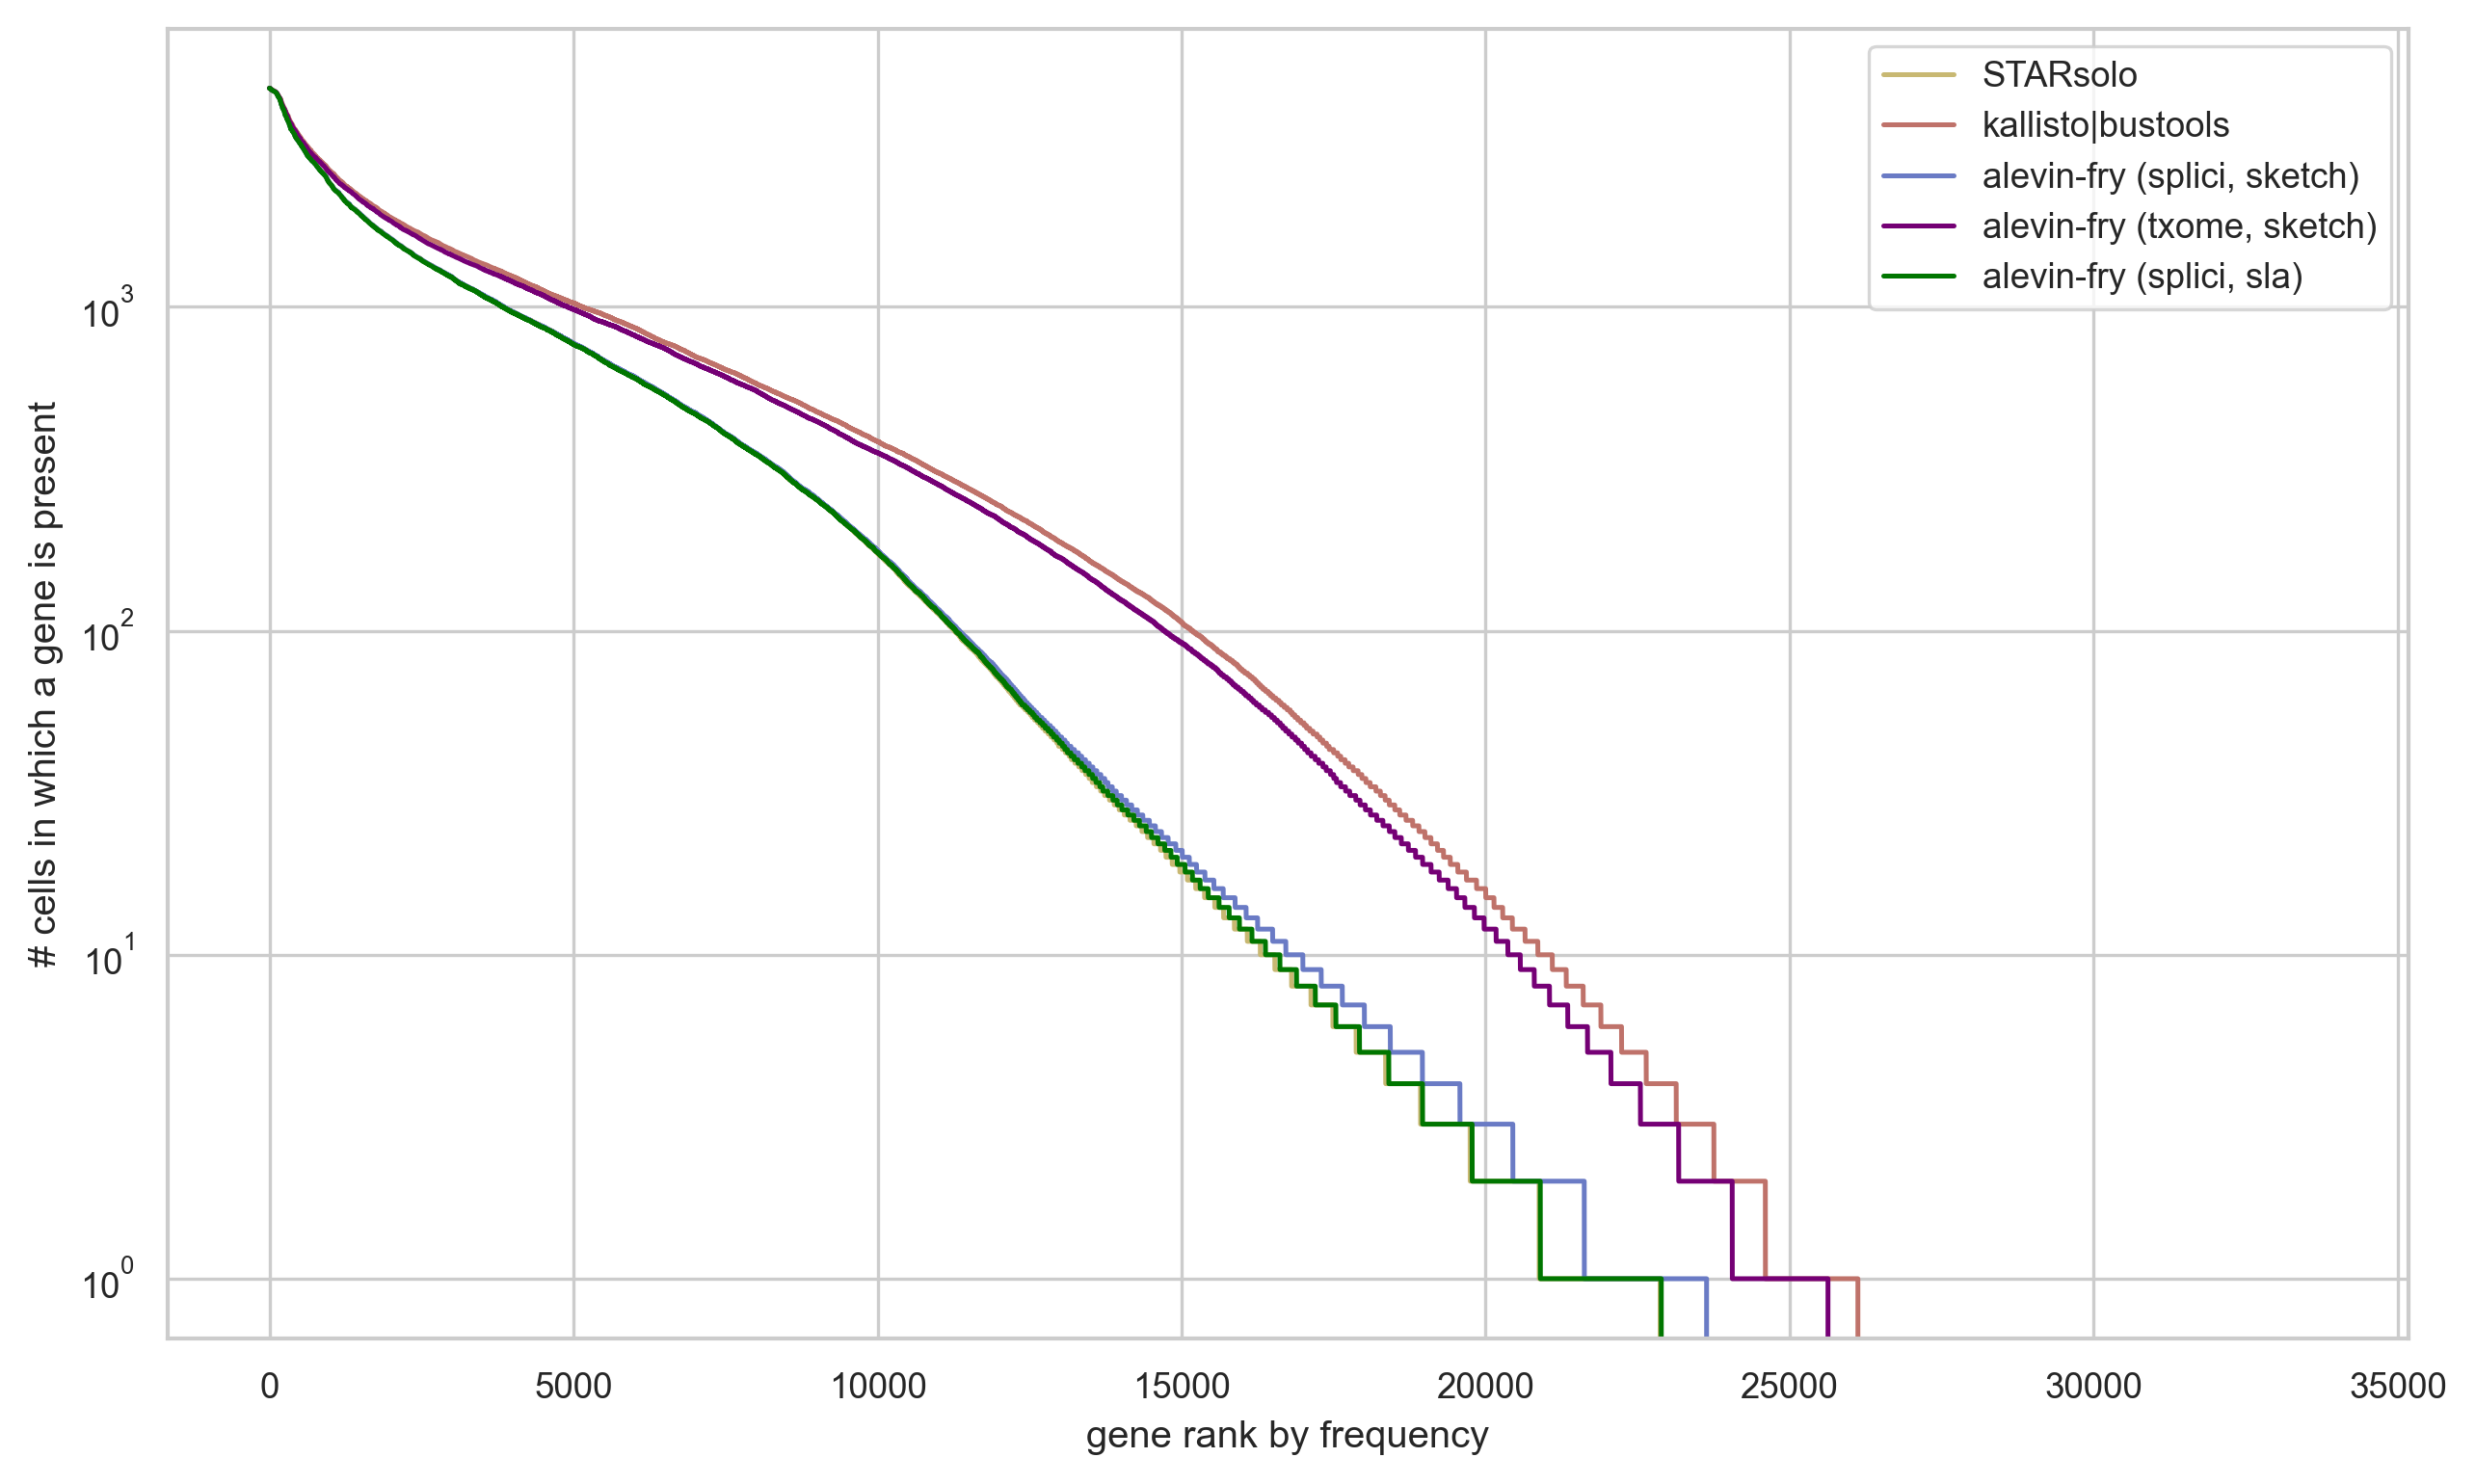

In [26]:
plot_nz_decay(
	{'STARsolo' : starsolo, 'kallisto|bustools' : kb, 
	'alevin-fry (splici, sketch)' : alevin_fry_splici_sketch, 
	'alevin-fry (txome, sketch)' : alevin_fry_txome_sketch, 
	'alevin-fry (splici, sla)' : alevin_fry_splici_sla },
	shared_genes, shared_cells)

Plot the distribution of per-cell Spearman correlations

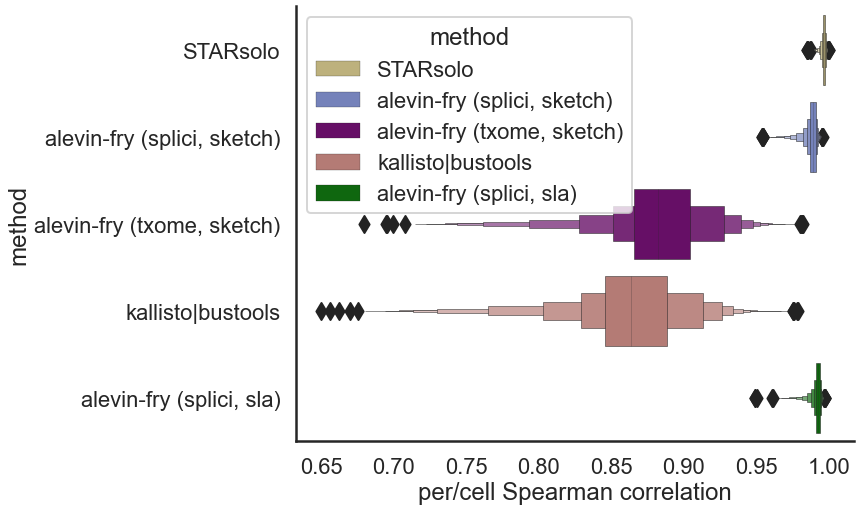

In [27]:
plot_spearman_dists({'STARsolo' : solo_res, 'alevin-fry (splici, sketch)' : splici_sketch_res, 'alevin-fry (txome, sketch)' : txome_sketch_res, 'kallisto|bustools' : kb_res, 'alevin-fry (splici, sla)' : splici_sla_res })